<a href="https://colab.research.google.com/github/tomonari-masada/course2023-sml/blob/main/07_linear_regression_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 重回帰による住宅価格の予測

* California housing datasetという有名なデータセットを使う。

 * scikit-learnからロードできるバージョンは、前処理が済んだキレイなデータなので、ここでは使わない。

* データの取得や前処理の一部は、
[Aurélien Géron. Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow, 2nd Edition.](https://www.oreilly.com/library/view/hands-on-machine-learning/9781492032632/) の2章と同じ。

* 機械学習において線形回帰モデルを使うときは、予測性能が最重要
 * 予測性能が上がるなら何でもする、という考え方。

In [ ]:
import numpy as np
from scipy import stats, special
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

%config InlineBackend.figure_format = 'retina'

## 1) データを取得

In [ ]:
import os
import tarfile
from six.moves import urllib

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
  os.makedirs(housing_path, exist_ok=True)
  tgz_path = os.path.join(housing_path, "housing.tgz")
  urllib.request.urlretrieve(housing_url, tgz_path)
  housing_tgz = tarfile.open(tgz_path)
  housing_tgz.extractall(path=housing_path)
  housing_tgz.close()

In [ ]:
fetch_housing_data()

In [ ]:
def load_housing_data(housing_path=HOUSING_PATH):
  csv_path = os.path.join(housing_path, "housing.csv")
  return pd.read_csv(csv_path)

（ここより上の詳細はフォローしなくてもいいいです。）

In [ ]:
housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


## 2) データを概観しつつ前処理

In [ ]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


* 数値データではない列が一つだけある

In [ ]:
housing['ocean_proximity'].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

* この数値データではない列を消してしまう
 * ここを変更してもいいです。

In [ ]:
housing_num = housing.drop('ocean_proximity', axis=1)

In [ ]:
housing_num.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB


* total_bedroomsは欠測箇所がある。
 * 後で対処する。

* median_house_valueを予測する、という問題設定。
 * これ以外は特徴量として使う。

In [ ]:
X = housing_num.drop('median_house_value', axis=1)
y = housing_num["median_house_value"].copy()

## 3) 評価実験のための準備

* 訓練データ、検証データ、テストデータに分ける
 * 今回は、6:2:2になるように分ける。（この比率に深い意味はない。）

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

In [ ]:
print(X_train.shape, X_valid.shape, X_test.shape)

(12384, 8) (4128, 8) (4128, 8)


* total_bedroomsの値が欠けているエントリがある
  * ここでは単に削除することにする（ここを変更してもいいです）。
  * isna()メソッドでNA valuesがある行を調べて、Xとyの両方に使う。

In [ ]:
na_index = X_train.isna().any(axis=1)
X_train = X_train[~ na_index]
y_train = y_train[~ na_index]

na_index = X_valid.isna().any(axis=1)
X_valid = X_valid[~ na_index]
y_valid = y_valid[~ na_index]

na_index = X_test.isna().any(axis=1)
X_test = X_test[~ na_index]
y_test = y_test[~ na_index]

In [ ]:
print(X_train.shape, X_valid.shape, X_test.shape)

(12384, 8) (4128, 8) (3921, 8)


* 交差検証をしてもらってもいいです。

## 4) 訓練データをよくよくながめてみる

 * EDA (exploratory data analysis) をおこなう

In [ ]:
X_train.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
count,12384.000000,12384.000000,12384.000000,12384.000000,12384.000000,12384.000000,12384.000000,12384.000000
mean,-119.579831,35.642003,28.585837,2633.748950,537.035368,1427.289648,499.044089,3.870090
std,2.005077,2.130977,12.608072,2137.057303,412.252061,1140.978664,375.749834,1.888237
min,-124.350000,32.560000,1.000000,2.000000,2.000000,3.000000,2.000000,0.499900
25%,-121.800000,33.930000,18.000000,1461.000000,298.000000,790.000000,282.000000,2.562500
50%,-118.500000,34.260000,29.000000,2127.000000,438.000000,1170.000000,412.000000,3.552100
75%,-118.010000,37.720000,37.000000,3150.000000,647.250000,1726.000000,606.000000,4.740400
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100


### ヒストグラム
 * cf. Aurélien Géron. Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow, 2nd Edition. p.50

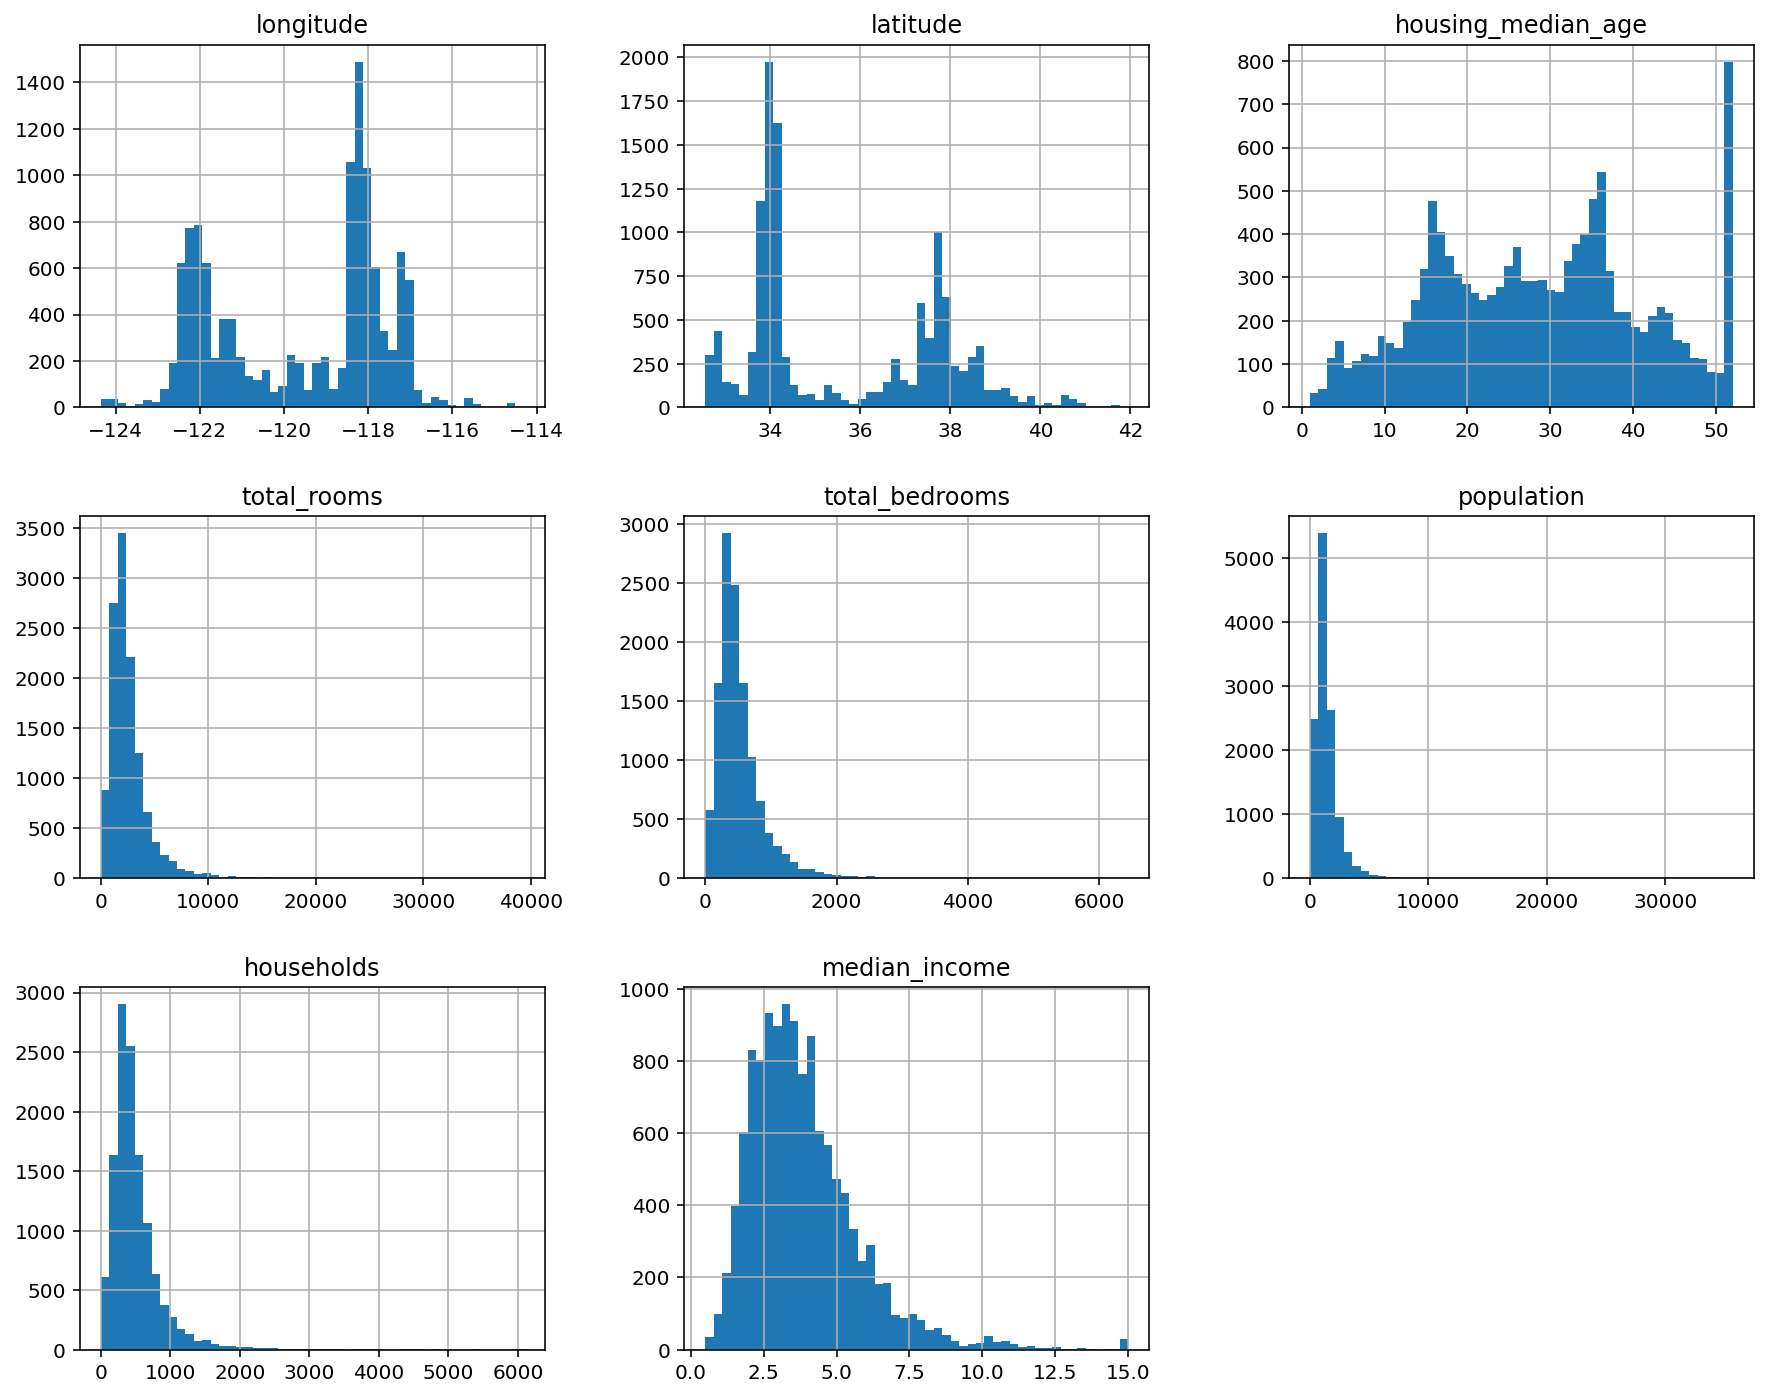

In [ ]:
X_train.hist(bins=50, figsize=(15,12));

* total_roomsの値の分布に注目してみる

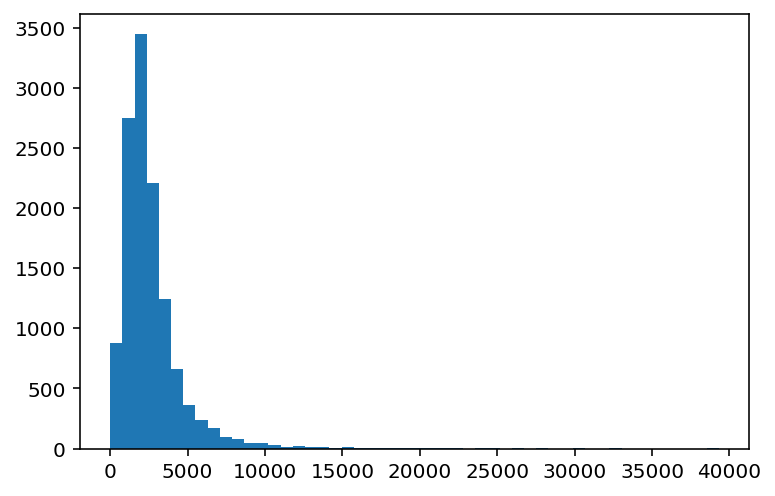

In [ ]:
plt.hist(X_train.total_rooms, bins=50);

* 説明変数の値がどのように分布するかは、回帰モデルの予測性能に直接は関係しない。
 * 回帰モデルでは、誤差項が正規分布に従うという仮定はする。
 * しかし、説明変数の値の分布については、何も仮定しない。
  * 例えば、0か1かの2通りの値しかとらない説明変数もよく使う。
 * とはいえ、それで予測性能が上がるなら、説明変数の値の分布を変更してみる余地はある。

* total_roomsについて、scipyのBox-Cox変換を適用して、ヒストグラムを描いてみる
 * scikit-learnでもBox-Cox変換はできる。

0.22454718388591666


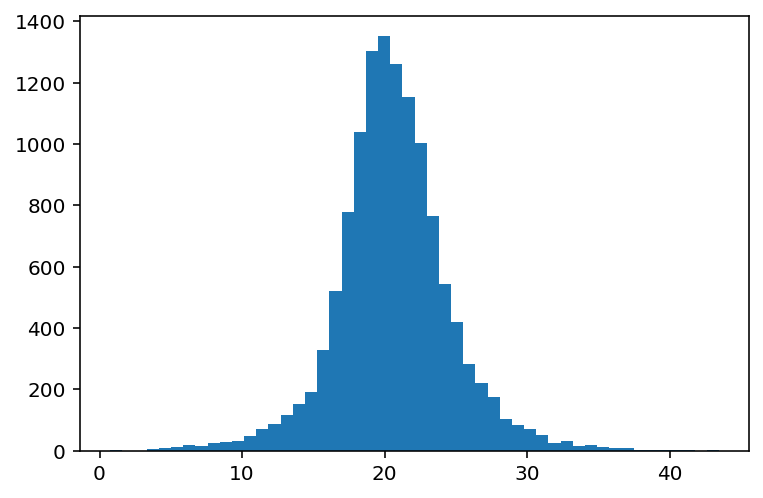

In [ ]:
boxcox_, maxlog_ = stats.boxcox(X_train.total_rooms)
plt.hist(boxcox_, bins=50);
print(maxlog_)
# （maxlog_ の部分は、test setなど、別のデータ集合を同じ条件で変換するときに使う。）

* Box-Cox変換の戻し方

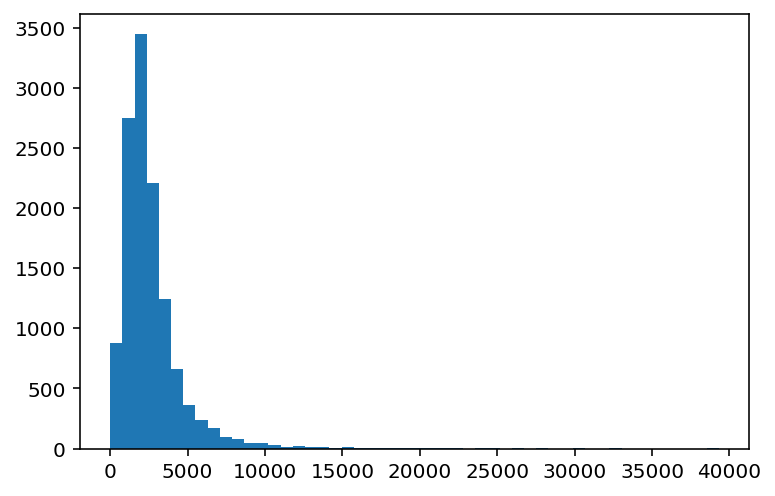

In [ ]:
plt.hist(special.inv_boxcox(boxcox_, maxlog_), bins=50);

* 変換した後のデータを使うほうが予測性能がよくなるかどうか、後で試してみよう。

* housing_median_ageを見てみる
 * 最大値の頻度が妙に高い。

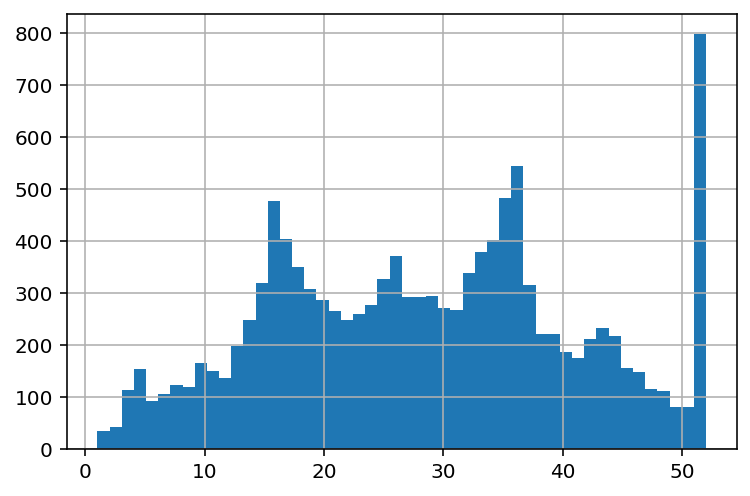

In [ ]:
X_train.housing_median_age.hist(bins=50);

In [ ]:
X_train.housing_median_age.value_counts().head()

52.0    775
36.0    543
35.0    482
16.0    477
17.0    404
Name: housing_median_age, dtype: int64

### 相関係数のヒートマップ
 * 多重共線性 https://bellcurve.jp/statistics/glossary/1792.html

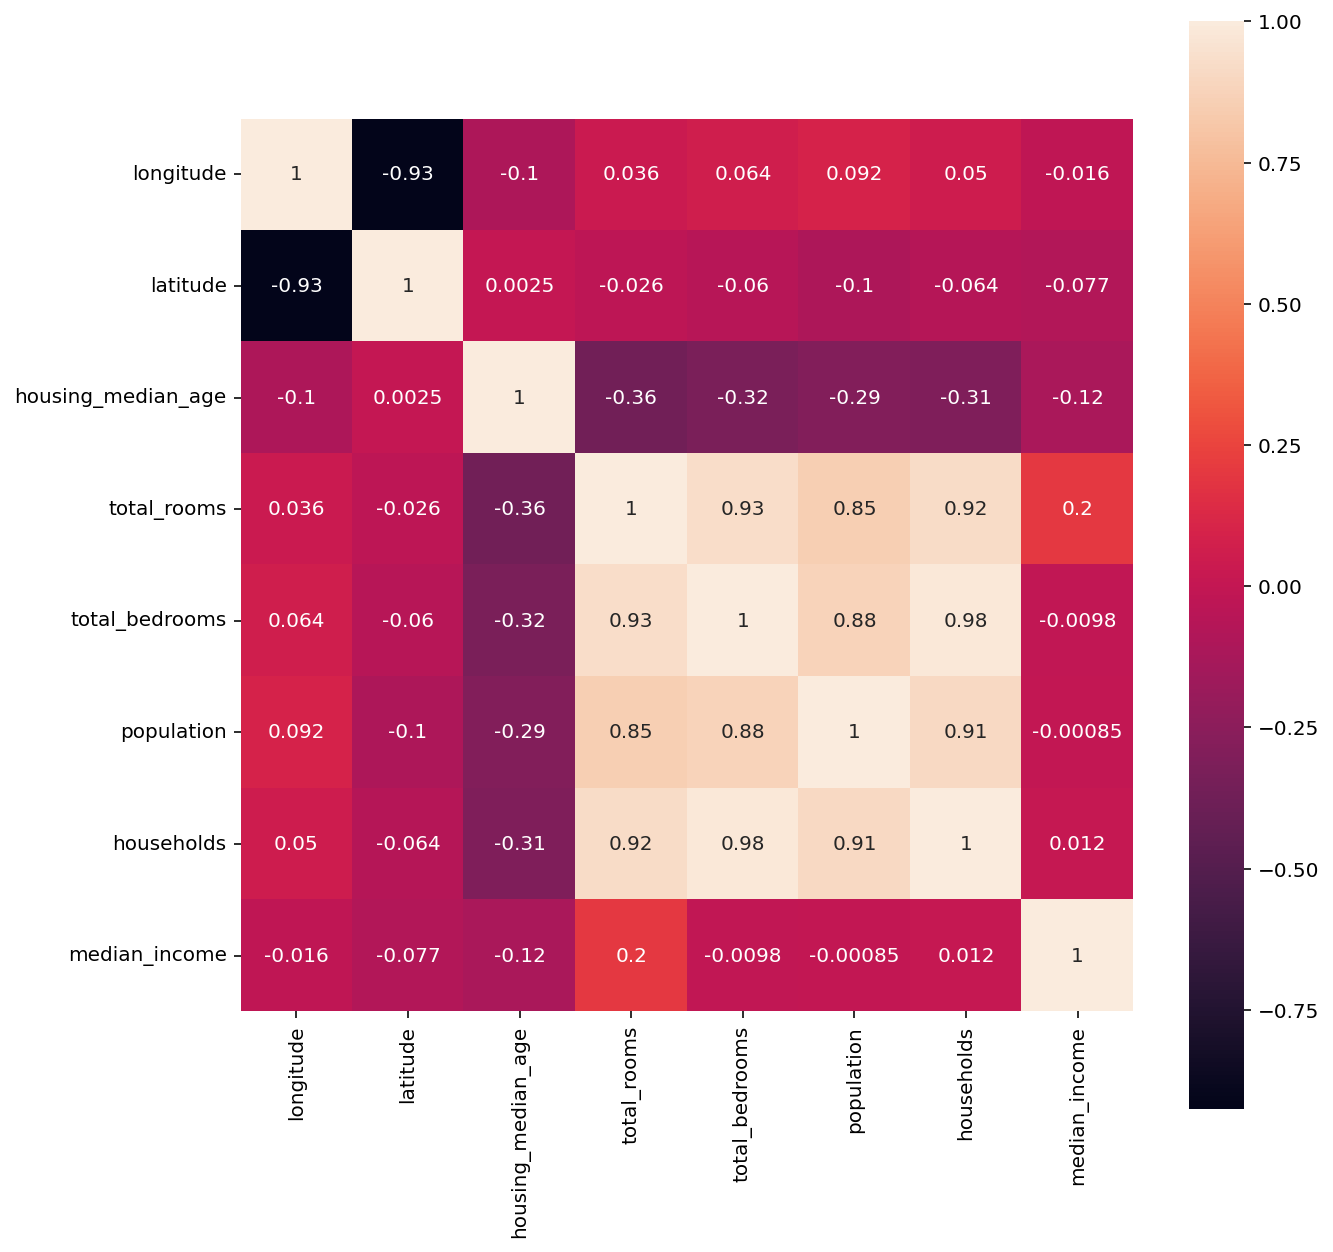

In [ ]:
plt.subplots(figsize=(10,10))
sns.heatmap(X_train.corr(), annot=True, square=True);

### ペア・プロット

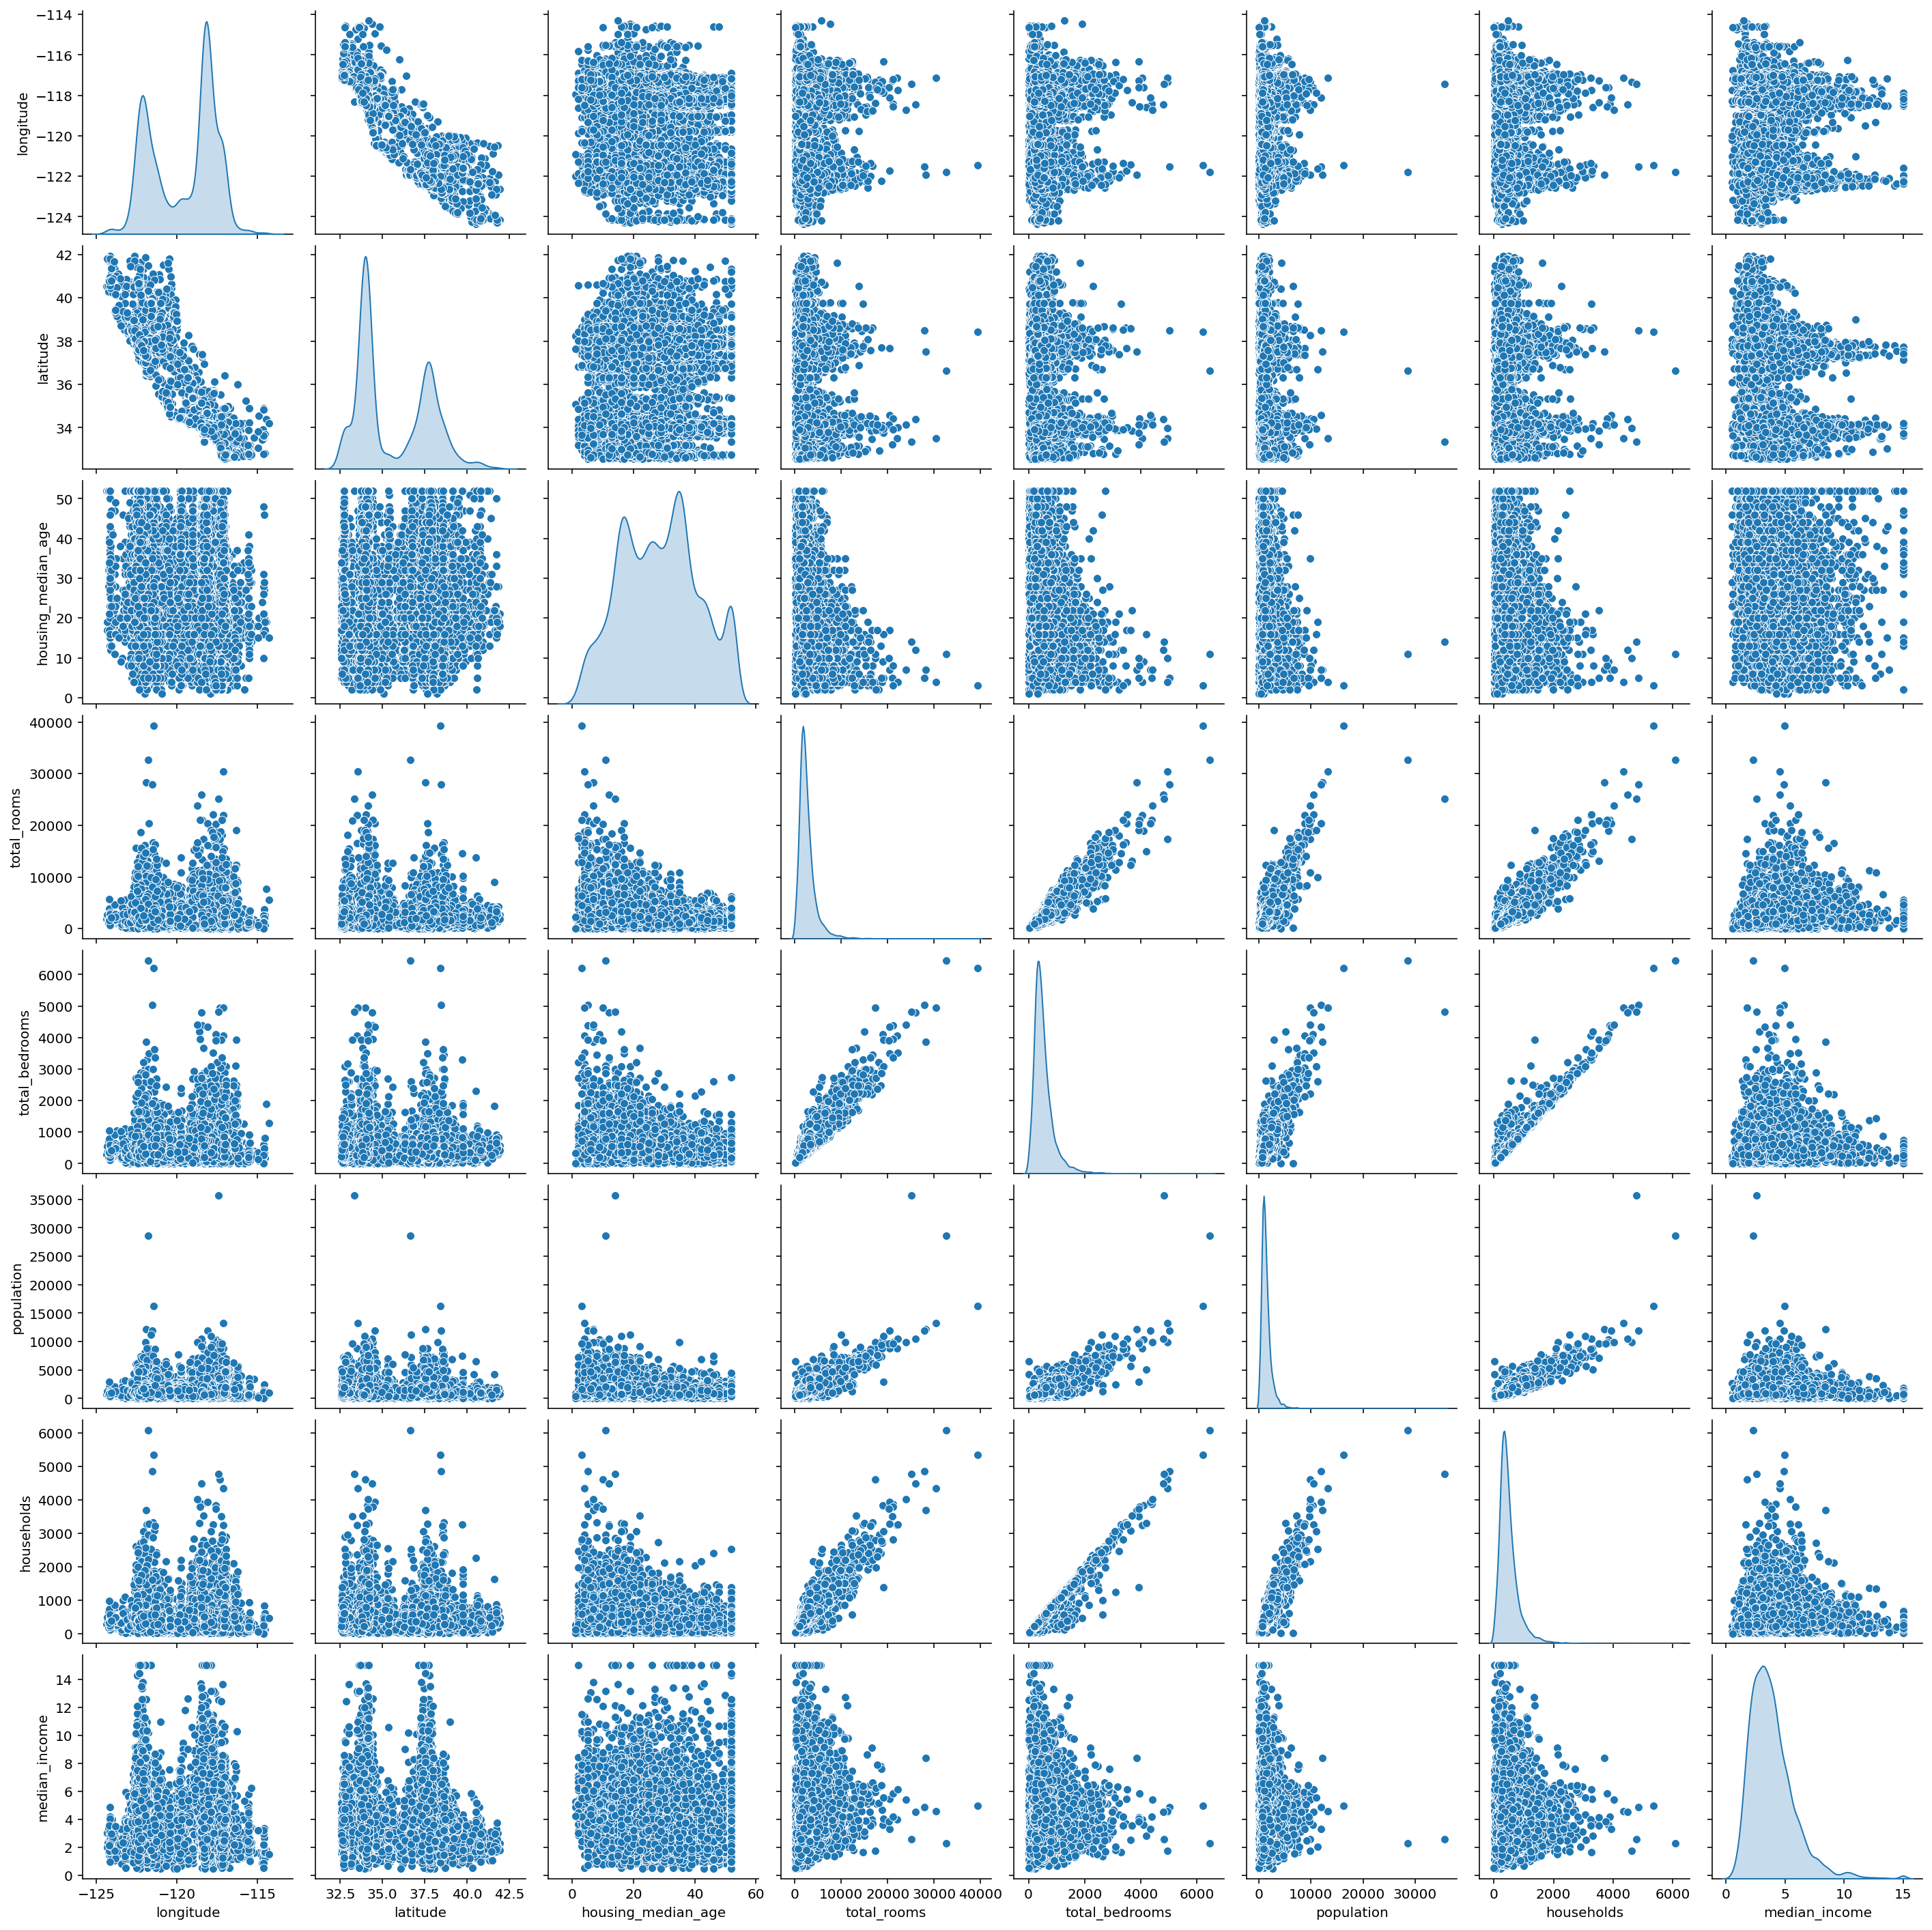

In [ ]:
sns.pairplot(X_train, diag_kind='kde');

## 5) 線形回帰

* training set上でモデル・パラメータを決定する


In [ ]:
reg = LinearRegression()
reg.fit(X_train, y_train)

LinearRegression()

* validation set上で評価する


In [ ]:
y_valid_pred = reg.predict(X_valid)
rmse = mean_squared_error(y_valid, y_valid_pred, squared=False)
print(f'RMSE: {rmse:f}')

RMSE: 69623.673261


* ここでターゲット（目的変数）の値の分布を見てみる

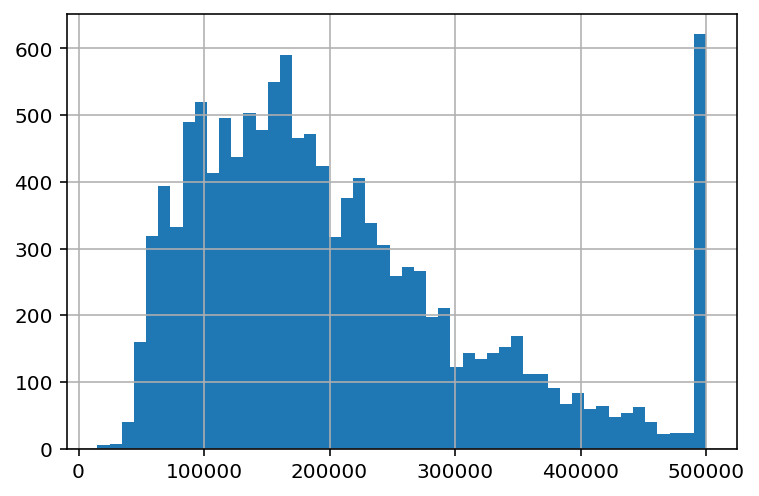

In [ ]:
y_train.hist(bins=50);

In [ ]:
y_train.value_counts().head()

500001.0    579
162500.0     78
137500.0     72
112500.0     61
187500.0     52
Name: median_house_value, dtype: int64

* 予測値が、訓練データ内でのターゲットの最大値を超えないようにして、再び評価する

In [ ]:
y_valid_pred = reg.predict(X_valid)
y_valid_pred[y_valid_pred > y_train.max()] = y_train.max()
rmse = mean_squared_error(y_valid, y_valid_pred, squared=False)
print(f'RMSE: {rmse:f}')

RMSE: 68517.794591


## 6) リッジ回帰
* 係数の二乗の和を抑える正則化を含む。

In [ ]:
from sklearn.linear_model import Ridge

reg = Ridge(alpha=1.0)
reg.fit(X_train, y_train)
y_valid_pred = reg.predict(X_valid)
y_valid_pred[y_valid_pred > y_train.max()] = y_train.max()
print('RMSE: {:f}'.format(mean_squared_error(y_valid, y_valid_pred, squared=False)))

RMSE: 68517.647048


## 7) Lasso
* 係数の絶対値の和を抑える正則化を含む。

In [ ]:
from sklearn.linear_model import Lasso

reg = Lasso(alpha=1.0)
reg.fit(X_train, y_train)
y_valid_pred = reg.predict(X_valid)
y_valid_pred[y_valid_pred > y_train.max()] = y_train.max()
print('RMSE: {:f}'.format(mean_squared_error(y_valid, y_valid_pred, squared=False)))

RMSE: 68517.757848


## 8) 試行錯誤するための選択肢

### 説明変数の値を加工
 * Box-Cox変換（既述）
 * MinMaxScaler

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(X_train) # スケーラのfitは訓練データのみで行う
X_train_scaled = X_train.copy()
X_train_scaled[X_train.columns] = scaler.transform(X_train)
X_valid_scaled = X_valid.copy()
X_valid_scaled[X_valid.columns] = scaler.transform(X_valid) # 検証データに同じスケーリングを適用

In [ ]:
X_train_scaled.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
count,12384.000000,12384.000000,12384.000000,12384.000000,12384.000000,12384.000000,12384.000000,12384.000000
mean,0.475116,0.328222,0.540899,0.066935,0.083041,0.039920,0.081751,0.232424
std,0.199709,0.226941,0.247217,0.054353,0.063984,0.031979,0.061801,0.130221
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.253984,0.145900,0.333333,0.037108,0.045941,0.022058,0.046053,0.142246
50%,0.582669,0.181044,0.549020,0.054046,0.067670,0.032708,0.067434,0.210494
75%,0.631474,0.549521,0.705882,0.080065,0.100147,0.048292,0.099342,0.292444
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### 正則化パラメータをチューニング

In [ ]:
for alpha in 10. ** np.arange(-6, 7):
  reg = Ridge(alpha=alpha, random_state=123)
  reg.fit(X_train_scaled, y_train)
  y_valid_pred = reg.predict(X_valid_scaled)
  y_valid_pred[y_valid_pred > y_train.max()] = y_train.max()
  rmse = mean_squared_error(y_valid, y_valid_pred, squared=False)
  print(f'alpha: {alpha:f}; RMSE: {rmse:f}')

alpha: 0.000001; RMSE: 68517.794773
alpha: 0.000010; RMSE: 68517.796408
alpha: 0.000100; RMSE: 68517.812768
alpha: 0.001000; RMSE: 68517.976913
alpha: 0.010000; RMSE: 68519.672943
alpha: 0.100000; RMSE: 68541.627489
alpha: 1.000000; RMSE: 68963.033020
alpha: 10.000000; RMSE: 71669.569428
alpha: 100.000000; RMSE: 80809.719433
alpha: 1000.000000; RMSE: 105929.993661
alpha: 10000.000000; RMSE: 115774.765610
alpha: 100000.000000; RMSE: 117044.708045
alpha: 1000000.000000; RMSE: 117175.664183


In [ ]:
reg = LinearRegression()
reg.fit(X_train_scaled, y_train)
y_valid_pred = reg.predict(X_valid_scaled)
y_valid_pred[y_valid_pred > y_train.max()] = y_train.max()
rmse = mean_squared_error(y_valid, y_valid_pred, squared=False)
print(f'RMSE: {rmse:f}')

RMSE: 68517.794591


### 試行錯誤の例：新しい説明変数を作成

* 下の例では、何をしているだろうか？

In [ ]:
print(X_train.longitude.median(), X_train.latitude.median())

-118.5 34.26


In [ ]:
med_lon = X_train.longitude.median()
med_lat = X_train.latitude.median()

In [ ]:
flag_lon = (X_train.longitude < med_lon) * 1
flag_lat = (X_train.latitude < med_lat) * 1

X_train['lon'] = flag_lon
X_train['lat'] = flag_lat

In [ ]:
X_train.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,lon,lat
count,12384.000000,12384.000000,12384.000000,12384.000000,12384.000000,12384.000000,12384.000000,12384.000000,12384.000000,12384.000000
mean,-119.579831,35.642003,28.585837,2633.748950,537.035368,1427.289648,499.044089,3.870090,0.499839,0.497901
std,2.005077,2.130977,12.608072,2137.057303,412.252061,1140.978664,375.749834,1.888237,0.500020,0.500016
min,-124.350000,32.560000,1.000000,2.000000,2.000000,3.000000,2.000000,0.499900,0.000000,0.000000
25%,-121.800000,33.930000,18.000000,1461.000000,298.000000,790.000000,282.000000,2.562500,0.000000,0.000000
50%,-118.500000,34.260000,29.000000,2127.000000,438.000000,1170.000000,412.000000,3.552100,0.000000,0.000000
75%,-118.010000,37.720000,37.000000,3150.000000,647.250000,1726.000000,606.000000,4.740400,1.000000,1.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,1.000000,1.000000


In [ ]:
flag_lon = (X_valid.longitude < med_lon) * 1
flag_lat = (X_valid.latitude < med_lat) * 1

X_valid['lon'] = flag_lon
X_valid['lat'] = flag_lat

In [ ]:
scaler = MinMaxScaler()
scaler.fit(X_train) # スケーラのfitは訓練データのみで行う
X_train_scaled = X_train.copy()
X_train_scaled[X_train.columns] = scaler.transform(X_train)
X_valid_scaled = X_valid.copy()
X_valid_scaled[X_valid.columns] = scaler.transform(X_valid) # 検証データに同じスケーリングを適用

In [ ]:
reg = LinearRegression()
reg.fit(X_train_scaled, y_train)
y_valid_pred = reg.predict(X_valid_scaled)
y_valid_pred[y_valid_pred > y_train.max()] = y_train.max()
rmse = mean_squared_error(y_valid, y_valid_pred, squared=False)
print(f'RMSE: {rmse:f}')

RMSE: 67655.491802


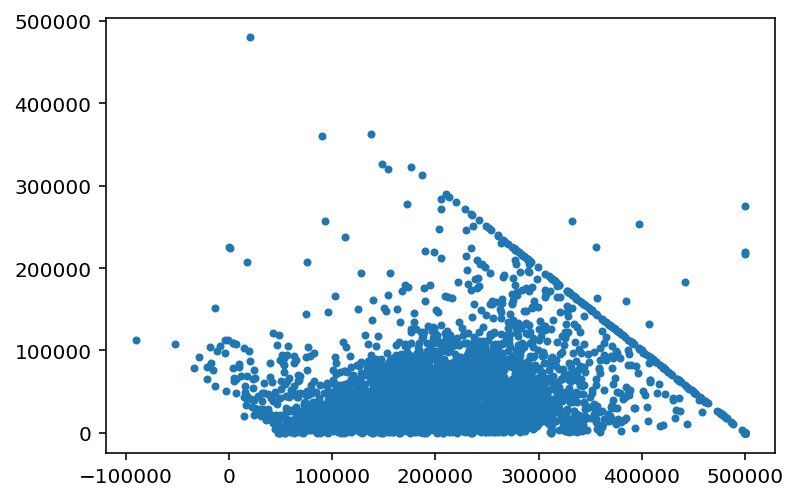

In [ ]:
plt.plot(y_valid_pred, np.abs(y_valid_pred - y_valid), '.');

# 課題7

* RMSEによって評価される予測性能を、良くして下さい
* test setとそれ以外の部分の分割は、変えないでください
 * test set以外の部分をどう使うかは、自由です。
 * training setとvalidation setをくっつけて、交差検証をしていいです。
* リッジ回帰とLassoを使ってもいいです
* 高次多項式特徴量を使ってもいいです（cf. `sklearn.preprocessing.PolynomialFeatures`）
* test setでのRMSEによる評価は最後に一回おこなうだけです